# A SplitFedLearning example based on MNIST Dataset

In [1]:

#mounting the drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

# me experimenting with the model
# me trying the SFL V1
# we have just 10 global rounds and only 5 client

rounds = 50
local_epochs = 1 # This has set to be 1 in the SFLG
users = 5 # number of clients 50, 

lr = 0.001

group_client_ordered = True # True means clients are grouped in order -- False means random selection
no_of_groups = users  # no. of groups/models in the process --- each group has several clients train sequentially at the server


In [3]:

import os
import h5py

import struct
import pickle
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time
from tqdm import tqdm
import numpy as np

import pandas
from pandas import DataFrame

from collections import defaultdict
import copy


In [4]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [5]:
root_path = '/content/drive/MyDrive/google_MNIST'
model_path = '/content/drive/MyDrive/google_MNIST/SplitFedComb_IID_model_%dusers_%dcopy.pth'%(users, no_of_groups)
acc_path = '/content/drive/MyDrive/google_MNIST/SplitFedComb_IID_acc_%dusers_%dcopy.hdf5'%(users, no_of_groups)

server_model_path = '/content/drive/MyDrive/google_MNIST/SplitFedComb_IID_%dusers_%dcopy.pth'%(users, no_of_groups)
client_model_path = '/content/drive/MyDrive/google_MNIST/SplitFedComb_IID__%dusers_%dcopy.pth'%(users, no_of_groups)


In [6]:
dataset = MNIST(root = root_path , download = False , transform = ToTensor())

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [9]:
print(len(dataset))

60000


# experimenting with mnist


In [ ]:
print(dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/drive/MyDrive/google_MNIST
    Split: Train
    StandardTransform
Transform: ToTensor()


In [ ]:
image, label = dataset[0]
print(label)

5


Label: 4


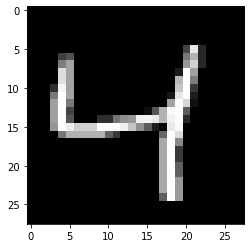

In [ ]:
image, label = dataset[2]
# plt.imshow(image.permute(1,2,0), cmap='gray')

plt.imshow(image.reshape(28,28), cmap="gray")

print('Label:', label)

In [ ]:

def split_indices( n , val_pct):
    # determining the size of the validation data
    n_val = int( n * val_pct)
    
    #creating the random permutaio of n numbers
    
    idxs = np.random.permutation(n)
    
    # we wil use the first n_val indices for our validation set
    
    return idxs[n_val : ] , idxs[: n_val]

In [ ]:
train_indices , val_indices = split_indices(len(dataset) , 0.2 )

# alternative syntax 
#train_indices , val_indices = split_indices(len(dataset) ,  val_pct = 0.2 )


In [ ]:
print(len(train_indices)," ", len(val_indices))

48000   12000


In [ ]:
print(train_indices)

[47888 54266 59255 ... 49918  9477 46605]


In [ ]:
indices_per_client = int (len(train_indices)/users)

print(indices_per_client)

9600


In [ ]:
batch_size = 100

train_loaders = []

train_datasets = []


for i in range(users):
  start= indices_per_client*i
  end= indices_per_client * (i+1)
  
  #print((train_indices[start:end]))

  
  train_datasets.append(list(train_indices[start:end]))

  #print(len(train_dataset))

  train_sampler = SubsetRandomSampler(train_indices[start : end])
  # train_loaders= DataLoader(dataset, batch_size, sampler= train_sampler) 
  train_loaders.append(DataLoader(dataset, batch_size=batch_size,sampler=train_sampler))

  
  # print(start, end)


#print(len(train_loaders))

# print(len(train_dataset[0]))
# print(train_dataset[1])


val_sampler = SubsetRandomSampler(val_indices)
#valid_dl in MNIST
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler) 



Grouping of the clients

In [ ]:
group_client_collect_dict = defaultdict(list)
# ordered division of clients in the group: group1 -- client0 to clientx
if group_client_ordered:
    #initialize
    start = 0
    step = int(users/no_of_groups)
    
    diff = users - step* no_of_groups
    #print(diff)
    
    if diff != 0:
        end = step + 1
        diff -= 1
    else:
        end = step
        
    for n in range(no_of_groups):
        
        clients_list = [i for i in range(start, end)]  
        group_client_collect_dict[n]= clients_list
        
        #print("Start, end:",start, end)
        
        if end+step <= users:
            start = copy.deepcopy(end)  
            if diff != 0:
                end += step + 1
                diff -= 1
            else:
                end += step
                
        else:
            start = copy.deepcopy(end)
            end = users
    
else:
    print("program is currently in group_client_ordered mode!")
    

    
    
print(group_client_collect_dict)

defaultdict(<class 'list'>, {0: [0], 1: [1], 2: [2], 3: [3], 4: [4]})


In [ ]:

#checking the batch size and dimension

x_train, y_train = next(iter(train_loaders[0]))
print(x_train.size())
print(y_train.size())

torch.Size([100, 1, 28, 28])
torch.Size([100])


In [ ]:
#checking sum of all batch 

# 24000 datasize per client, when client=2, batchsize=100, total batches = 24000/100=240
# testing datast = 12000, batchsize=100 , total testing batches =12000/100 =120


train_total_batch = len(train_loaders[0])
print(train_total_batch)
test_batch = len(test_loader)
print(test_batch)

96
120


In [ ]:
# Dataset size for the serverside -- group wise averaging

datasetsize_server = []
len_dataset = 0
for g in range(no_of_groups):
    for idx in group_client_collect_dict[g]:
        len_dataset += len(train_datasets[idx])
    datasetsize_server.append(len_dataset)
    len_dataset = 0


# Dataset size for the client-size -- client wise averaging   
datasetsize_client = []
for i in range(users):
  datasetsize_client.append(len(train_datasets[i]))

In [ ]:
print(datasetsize_client)

[9600, 9600, 9600, 9600, 9600]


# main model

In [ ]:
class MnistNet(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        #hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        
        self.linear3 = nn.Linear(hidden_size, hidden_size)

        self.linear4 = nn.Linear(hidden_size, hidden_size)
    


        #out layer
        self.linear2 = nn.Linear(hidden_size, out_size)


    
    def forward(self,xb):
        # flatten the tensors to size 100x784
        xb = xb.view(xb.size(0),-1)
        # get intermediate outputs from the hidden layer
        
        out = self.linear1(xb)
        
        # apply activation function ReLU
        
        out = F.relu(out)


        out = self.linear3(out)

        out = F.relu(out)


        out = self.linear4(out)
        out = F.relu(out) 

        # get the prediction using the output layer
        
        out = self.linear2(out)
        
        return out
        
        

In [ ]:
input_size = 784
num_classes = 10

#model in MNIST
mnist_net = MnistNet(input_size, hidden_size = 32, out_size = num_classes )

In [ ]:
mnist_net.to(device)

MnistNet(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

# Mnist_client

In [ ]:
class MnistClient(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        #hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        
        self.linear3 = nn.Linear(hidden_size, hidden_size)

        # self.linear4 = nn.Linear(hidden_size, hidden_size)
    
        # #out layer
        # self.linear2 = nn.Linear(hidden_size, out_size)


    
    def forward(self,xb):
        # flatten the tensors to size 100x784
        xb = xb.view(xb.size(0),-1)
        # get intermediate outputs from the hidden layer
        
        out = self.linear1(xb)
        
        # apply activation function ReLU
        
        out = F.relu(out)


        out = self.linear3(out)

        out = F.relu(out)


        # out = self.linear4(out)
        # out = F.relu(out) 

        # # get the prediction using the output layer
        
        # out = self.linear2(out)
        
        return out
        
        

In [ ]:
input_size = 784
num_classes = 10


mnist_client = MnistClient(input_size, hidden_size = 32, out_size = num_classes )
mnist_client.to(device)

MnistClient(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=32, bias=True)
)

# mnist server

In [ ]:
class MnistServer(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        #hidden layer
        # self.linear1 = nn.Linear(in_size, hidden_size)
        
        # self.linear3 = nn.Linear(hidden_size, hidden_size)

        self.linear4 = nn.Linear(hidden_size, hidden_size)
    
        #out layer
        self.linear2 = nn.Linear(hidden_size, out_size)


    
    def forward(self,xb):
        # flatten the tensors to size 100x784
        # xb = xb.view(xb.size(0),-1)
        # # get intermediate outputs from the hidden layer
        
        # out = self.linear1(xb)
        
        # # apply activation function ReLU
        
        # out = F.relu(out)


        # out = self.linear3(out)

        # out = F.relu(out)


        out = self.linear4(xb)
        out = F.relu(out) 

        # get the prediction using the output layer
        
        out = self.linear2(out)
        
        return out
        
        

In [ ]:
input_size = 784
num_classes = 10



mnist_server= MnistServer(input_size, hidden_size = 32, out_size = num_classes)
mnist_server.to(device)

MnistServer(
  (linear4): Linear(in_features=32, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

# variable

In [ ]:
clientsoclist = []
train_total_batch = []

criterion = nn.CrossEntropyLoss()
train_acc = []
val_acc = []
train_lo = []
val_lo = []
train_acc_average=[]

optimizer = Adam(mnist_net.parameters(), lr=lr)
optimizer_client = Adam(mnist_client.parameters(), lr=lr)
optimizer_server = Adam(mnist_server.parameters(), lr=lr)

weights_server_list_group = []
weights_client_list_group = []

## Comunication overhead

In [ ]:
total_sendsize_list = []
total_receivesize_list = []

client_sendsize_list = [[] for i in range(users)]
client_receivesize_list = [[] for i in range(users)]

train_sendsize_list = [] 
train_receivesize_list = []

In [ ]:
import copy

def average_weights(w, datasize):
    """
    Returns the average of the weights.
    """
        
    for i, data in enumerate(datasize):
        for key in w[i].keys():
            w[i][key] *= float(data)
    
    w_avg = copy.deepcopy(w[0])
   
    for key in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[key] += w[i][key]
        w_avg[key] = torch.div(w_avg[key], float(sum(datasize)))


    return w_avg

## Receive users before training

In [ ]:
start_time = time.time()    # store start time
print("timmer start!")
# train()

timmer start!


# train

In [ ]:
group_client_weights_collect = []

# global weights at first
global_client_weights = copy.deepcopy(mnist_client.state_dict())
global_server_weights = copy.deepcopy(mnist_server.state_dict())

for r in range(rounds): 
    # initialize the weights of the model for this round
    round_client_weights = copy.deepcopy(global_client_weights)
    
    round_server_weights = copy.deepcopy(global_server_weights)  
    # we will run by groups ----
    for g in range(no_of_groups):
        # for each user in the group g
        #group_client_weights = copy.deepcopy(round_client_weights)
        group_server_weights = copy.deepcopy(round_server_weights)
        
        for u in group_client_collect_dict[g]:
            # model for user u
            #print("User:", u)
            
            # client has the same initial state for the group
            mnist_client.load_state_dict(round_client_weights)
            
            # server model state changes with clients
            mnist_server.load_state_dict(group_server_weights)

            for local_epoch in range(local_epochs):

                for data in tqdm(train_loaders[u], ncols=100, desc='Round'+str(r+1)+': User'+str(u)+'_'+str(local_epoch+1)):
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data
                    inputs = inputs.to(device)
                    labels = labels.clone().detach().long().to(device)

                    #------------ client forward training -----------
                    optimizer_client.zero_grad()
                    output_client = mnist_client(inputs)
                    client_output = output_client.clone().detach().requires_grad_(True)

                    # ---------- server forward/backward training ------------
                    optimizer_server.zero_grad()
                    output = mnist_server(client_output)
                    loss = criterion(output, labels)
                    loss.backward()
                    optimizer_server.step()
                    client_grad = client_output.grad.clone().detach()

                    # ----------- client backward training ------------
                    output_client.backward(client_grad)
                    optimizer_client.step()
            


            # going for next user in the same group
            client_weights = copy.deepcopy(mnist_client.state_dict())
            group_client_weights_collect.append(client_weights) 
            
            group_server_weights = copy.deepcopy(mnist_server.state_dict())
            
            
        
        # Now going for the different group
        # save the weights of the current model -- current group
        
        weights_server_list_group.append(group_server_weights)
        
        
    # Completion for all groups
    # average
    global_client_weights = average_weights(group_client_weights_collect, datasetsize_client)
    
    global_server_weights = average_weights(weights_server_list_group, datasetsize_server)
    
    weights_server_list_group = []
    group_client_weights_collect = []
        
        
    #==============================================================================================    
    
    
    #================================================================================================================
    # Accuracy check at each round (this is for the gloabl model --- not local model) -------------
    # This is s result for the global model at each round --------
    mnist_client.load_state_dict(global_client_weights)
    mnist_server.load_state_dict(global_server_weights)
    mnist_client.eval()
    mnist_server.eval()
    
    # train acc for each client's training dataset
    # train acc
    with torch.no_grad():
        for u in range(users):
            corr_num = 0
            total_num = 0
            train_loss = 0.0
            for j, trn in enumerate(train_loaders[u]):
                trn_x, trn_label = trn
                trn_x = trn_x.to(device)
                trn_label = trn_label.clone().detach().long().to(device)

                trn_output = mnist_client(trn_x)
                trn_output = mnist_server(trn_output)
                loss = criterion(trn_output, trn_label)
                train_loss += loss.item()
                model_label = trn_output.argmax(dim=1)
                corr = trn_label[trn_label == model_label].size(0)
                corr_num += corr
                total_num += trn_label.size(0)
            train_accuracy = corr_num / total_num * 100
            r_train_loss = train_loss / len(train_loaders[u])
            print("client {}: rounds {}'s train_acc: {:.2f}%, train_loss: {:.4f}".format(u, r + 1, train_accuracy, r_train_loss))
            train_acc.append(train_accuracy)
        avg_acc = sum(train_acc)/len(train_acc)
        print("Train_average accuracy:", avg_acc)
        train_acc_average.append(avg_acc)
        train_acc = []
    # test acc
    with torch.no_grad():
        corr_num = 0
        total_num = 0
        val_loss = 0.0
        for j, val in enumerate(test_loader):
            val_x, val_label = val
            val_x = val_x.to(device)
            val_label = val_label.clone().detach().long().to(device)

            val_output = mnist_client(val_x)
            val_output = mnist_server(val_output)
            loss = criterion(val_output, val_label)
            val_loss += loss.item()
            model_label = val_output.argmax(dim=1)
            corr = val_label[val_label == model_label].size(0)
            corr_num += corr
            total_num += val_label.size(0)
        test_accuracy = corr_num / total_num * 100
        test_loss = val_loss / len(test_loader)
        print("rounds {}'s test_acc: {:.2f}%, test_loss: {:.4f}".format(r + 1, test_accuracy, test_loss))
        val_acc.append(test_accuracy)

end_time = time.time()  # store end time
print("TrainingTime: {} sec".format(end_time - start_time))

Round1: User4_1: 100%|██████████████████████████████████████████████| 96/96 [00:01<00:00, 95.15it/s]


client 0: rounds 1's train_acc: 77.67%, train_loss: 0.9378
client 1: rounds 1's train_acc: 78.07%, train_loss: 0.9403
client 2: rounds 1's train_acc: 78.00%, train_loss: 0.9446
client 3: rounds 1's train_acc: 77.06%, train_loss: 0.9574
client 4: rounds 1's train_acc: 77.56%, train_loss: 0.9396
Train_average accuracy: 77.67291666666667


Round2: User0_1:  10%|████▊                                         | 10/96 [00:00<00:00, 95.58it/s]

rounds 1's test_acc: 78.17%, test_loss: 0.9473


Round2: User4_1: 100%|██████████████████████████████████████████████| 96/96 [00:00<00:00, 96.33it/s]


client 0: rounds 2's train_acc: 88.08%, train_loss: 0.4212
client 1: rounds 2's train_acc: 88.08%, train_loss: 0.4251
client 2: rounds 2's train_acc: 88.00%, train_loss: 0.4293
client 3: rounds 2's train_acc: 86.94%, train_loss: 0.4506
client 4: rounds 2's train_acc: 87.84%, train_loss: 0.4263
Train_average accuracy: 87.78958333333334


Round3: User0_1:  10%|████▊                                         | 10/96 [00:00<00:00, 95.85it/s]

rounds 2's test_acc: 87.65%, test_loss: 0.4405


Round3: User4_1: 100%|██████████████████████████████████████████████| 96/96 [00:00<00:00, 97.80it/s]


client 0: rounds 3's train_acc: 89.81%, train_loss: 0.3518
client 1: rounds 3's train_acc: 89.93%, train_loss: 0.3547
client 2: rounds 3's train_acc: 89.96%, train_loss: 0.3594
client 3: rounds 3's train_acc: 88.84%, train_loss: 0.3819
client 4: rounds 3's train_acc: 89.96%, train_loss: 0.3560
Train_average accuracy: 89.69999999999999


Round4: User0_1:  10%|████▊                                         | 10/96 [00:00<00:00, 95.19it/s]

rounds 3's test_acc: 89.71%, test_loss: 0.3678


Round4: User4_1: 100%|██████████████████████████████████████████████| 96/96 [00:01<00:00, 88.24it/s]


client 0: rounds 4's train_acc: 90.70%, train_loss: 0.3166
client 1: rounds 4's train_acc: 90.90%, train_loss: 0.3209
client 2: rounds 4's train_acc: 90.92%, train_loss: 0.3240
client 3: rounds 4's train_acc: 89.91%, train_loss: 0.3456
client 4: rounds 4's train_acc: 90.80%, train_loss: 0.3223
Train_average accuracy: 90.64375


Round5: User0_1:   9%|████▍                                          | 9/96 [00:00<00:00, 89.08it/s]

rounds 4's test_acc: 90.42%, test_loss: 0.3346


Round5: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:00<00:00, 100.91it/s]


client 0: rounds 5's train_acc: 91.51%, train_loss: 0.2943
client 1: rounds 5's train_acc: 91.58%, train_loss: 0.3004
client 2: rounds 5's train_acc: 91.21%, train_loss: 0.3024
client 3: rounds 5's train_acc: 90.48%, train_loss: 0.3237
client 4: rounds 5's train_acc: 91.50%, train_loss: 0.3013
Train_average accuracy: 91.25625000000001


Round6: User0_1:   4%|█▉                                             | 4/96 [00:00<00:02, 36.91it/s]

rounds 5's test_acc: 90.90%, test_loss: 0.3144


Round6: User4_1: 100%|██████████████████████████████████████████████| 96/96 [00:01<00:00, 89.66it/s]


client 0: rounds 6's train_acc: 92.28%, train_loss: 0.2744
client 1: rounds 6's train_acc: 92.08%, train_loss: 0.2809
client 2: rounds 6's train_acc: 92.09%, train_loss: 0.2816
client 3: rounds 6's train_acc: 91.29%, train_loss: 0.2997
client 4: rounds 6's train_acc: 92.26%, train_loss: 0.2801
Train_average accuracy: 92.00208333333333


Round7: User0_1:   9%|████▍                                          | 9/96 [00:00<00:00, 87.47it/s]

rounds 6's test_acc: 91.67%, test_loss: 0.2935


Round7: User4_1: 100%|██████████████████████████████████████████████| 96/96 [00:01<00:00, 93.08it/s]


client 0: rounds 7's train_acc: 92.61%, train_loss: 0.2562
client 1: rounds 7's train_acc: 92.67%, train_loss: 0.2625
client 2: rounds 7's train_acc: 92.33%, train_loss: 0.2641
client 3: rounds 7's train_acc: 91.48%, train_loss: 0.2837
client 4: rounds 7's train_acc: 92.81%, train_loss: 0.2631
Train_average accuracy: 92.38125


Round8: User0_1:  10%|████▊                                         | 10/96 [00:00<00:00, 92.06it/s]

rounds 7's test_acc: 91.99%, test_loss: 0.2774


Round8: User4_1: 100%|██████████████████████████████████████████████| 96/96 [00:00<00:00, 97.59it/s]


client 0: rounds 8's train_acc: 93.22%, train_loss: 0.2399
client 1: rounds 8's train_acc: 93.03%, train_loss: 0.2465
client 2: rounds 8's train_acc: 93.01%, train_loss: 0.2463
client 3: rounds 8's train_acc: 92.05%, train_loss: 0.2650
client 4: rounds 8's train_acc: 93.19%, train_loss: 0.2474
Train_average accuracy: 92.89999999999999


Round9: User0_1:  10%|████▊                                         | 10/96 [00:00<00:00, 93.68it/s]

rounds 8's test_acc: 92.47%, test_loss: 0.2617


Round9: User4_1: 100%|██████████████████████████████████████████████| 96/96 [00:01<00:00, 84.98it/s]


client 0: rounds 9's train_acc: 93.40%, train_loss: 0.2284
client 1: rounds 9's train_acc: 93.39%, train_loss: 0.2344
client 2: rounds 9's train_acc: 93.14%, train_loss: 0.2328
client 3: rounds 9's train_acc: 92.54%, train_loss: 0.2514
client 4: rounds 9's train_acc: 93.59%, train_loss: 0.2339
Train_average accuracy: 93.21041666666667


Round10: User0_1:  10%|████▋                                        | 10/96 [00:00<00:00, 93.98it/s]

rounds 9's test_acc: 92.82%, test_loss: 0.2475


Round10: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 94.16it/s]


client 0: rounds 10's train_acc: 93.81%, train_loss: 0.2132
client 1: rounds 10's train_acc: 93.89%, train_loss: 0.2188
client 2: rounds 10's train_acc: 93.58%, train_loss: 0.2186
client 3: rounds 10's train_acc: 92.88%, train_loss: 0.2350
client 4: rounds 10's train_acc: 94.11%, train_loss: 0.2209
Train_average accuracy: 93.65416666666667


Round11: User0_1:  10%|████▋                                        | 10/96 [00:00<00:00, 96.96it/s]

rounds 10's test_acc: 93.21%, test_loss: 0.2364


Round11: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:00<00:00, 97.79it/s]


client 0: rounds 11's train_acc: 93.98%, train_loss: 0.2053
client 1: rounds 11's train_acc: 94.04%, train_loss: 0.2092
client 2: rounds 11's train_acc: 94.11%, train_loss: 0.2097
client 3: rounds 11's train_acc: 93.34%, train_loss: 0.2248
client 4: rounds 11's train_acc: 94.23%, train_loss: 0.2125
Train_average accuracy: 93.94166666666668


Round12: User0_1:   9%|████▎                                         | 9/96 [00:00<00:00, 89.10it/s]

rounds 11's test_acc: 93.41%, test_loss: 0.2287


Round12: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:00<00:00, 98.21it/s]


client 0: rounds 12's train_acc: 94.33%, train_loss: 0.1963
client 1: rounds 12's train_acc: 94.38%, train_loss: 0.2007
client 2: rounds 12's train_acc: 93.96%, train_loss: 0.2003
client 3: rounds 12's train_acc: 93.30%, train_loss: 0.2161
client 4: rounds 12's train_acc: 94.46%, train_loss: 0.2029
Train_average accuracy: 94.08541666666666


Round13: User0_1:  10%|████▋                                        | 10/96 [00:00<00:00, 94.47it/s]

rounds 12's test_acc: 93.69%, test_loss: 0.2188


Round13: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:00<00:00, 97.65it/s]


client 0: rounds 13's train_acc: 94.55%, train_loss: 0.1876
client 1: rounds 13's train_acc: 94.68%, train_loss: 0.1903
client 2: rounds 13's train_acc: 94.55%, train_loss: 0.1905
client 3: rounds 13's train_acc: 93.82%, train_loss: 0.2039
client 4: rounds 13's train_acc: 94.68%, train_loss: 0.1935
Train_average accuracy: 94.45625


Round14: User0_1:   9%|████▎                                         | 9/96 [00:00<00:01, 83.75it/s]

rounds 13's test_acc: 93.82%, test_loss: 0.2105


Round14: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 94.11it/s]


client 0: rounds 14's train_acc: 94.71%, train_loss: 0.1808
client 1: rounds 14's train_acc: 94.92%, train_loss: 0.1839
client 2: rounds 14's train_acc: 94.54%, train_loss: 0.1827
client 3: rounds 14's train_acc: 94.04%, train_loss: 0.1968
client 4: rounds 14's train_acc: 94.98%, train_loss: 0.1882
Train_average accuracy: 94.63750000000002


Round15: User0_1:   9%|████▎                                         | 9/96 [00:00<00:00, 88.50it/s]

rounds 14's test_acc: 93.97%, test_loss: 0.2060


Round15: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 95.51it/s]


client 0: rounds 15's train_acc: 94.94%, train_loss: 0.1736
client 1: rounds 15's train_acc: 95.11%, train_loss: 0.1731
client 2: rounds 15's train_acc: 94.96%, train_loss: 0.1746
client 3: rounds 15's train_acc: 94.30%, train_loss: 0.1865
client 4: rounds 15's train_acc: 95.02%, train_loss: 0.1787
Train_average accuracy: 94.86666666666666


Round16: User0_1:  10%|████▋                                        | 10/96 [00:00<00:00, 93.15it/s]

rounds 15's test_acc: 94.26%, test_loss: 0.1982


Round16: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 89.43it/s]


client 0: rounds 16's train_acc: 95.23%, train_loss: 0.1675
client 1: rounds 16's train_acc: 95.52%, train_loss: 0.1677
client 2: rounds 16's train_acc: 95.08%, train_loss: 0.1681
client 3: rounds 16's train_acc: 94.56%, train_loss: 0.1791
client 4: rounds 16's train_acc: 95.39%, train_loss: 0.1726
Train_average accuracy: 95.15625


Round17: User0_1:   3%|█▍                                            | 3/96 [00:00<00:03, 27.49it/s]

rounds 16's test_acc: 94.47%, test_loss: 0.1927


Round17: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 93.77it/s]


client 0: rounds 17's train_acc: 95.32%, train_loss: 0.1619
client 1: rounds 17's train_acc: 95.72%, train_loss: 0.1594
client 2: rounds 17's train_acc: 95.29%, train_loss: 0.1616
client 3: rounds 17's train_acc: 94.75%, train_loss: 0.1732
client 4: rounds 17's train_acc: 95.49%, train_loss: 0.1655
Train_average accuracy: 95.31458333333335


Round18: User0_1:  10%|████▋                                        | 10/96 [00:00<00:00, 93.08it/s]

rounds 17's test_acc: 94.62%, test_loss: 0.1870


Round18: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 95.52it/s]


client 0: rounds 18's train_acc: 95.46%, train_loss: 0.1592
client 1: rounds 18's train_acc: 95.55%, train_loss: 0.1580
client 2: rounds 18's train_acc: 95.31%, train_loss: 0.1578
client 3: rounds 18's train_acc: 94.78%, train_loss: 0.1691
client 4: rounds 18's train_acc: 95.44%, train_loss: 0.1631
Train_average accuracy: 95.30833333333334


Round19: User0_1:  10%|████▋                                        | 10/96 [00:00<00:00, 97.51it/s]

rounds 18's test_acc: 94.73%, test_loss: 0.1861


Round19: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 91.44it/s]


client 0: rounds 19's train_acc: 95.77%, train_loss: 0.1511
client 1: rounds 19's train_acc: 96.07%, train_loss: 0.1480
client 2: rounds 19's train_acc: 95.57%, train_loss: 0.1492
client 3: rounds 19's train_acc: 95.14%, train_loss: 0.1608
client 4: rounds 19's train_acc: 95.74%, train_loss: 0.1547
Train_average accuracy: 95.65833333333332


Round20: User0_1:  10%|████▋                                        | 10/96 [00:00<00:00, 96.66it/s]

rounds 19's test_acc: 95.03%, test_loss: 0.1798


Round20: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 87.28it/s]


client 0: rounds 20's train_acc: 95.77%, train_loss: 0.1474
client 1: rounds 20's train_acc: 96.07%, train_loss: 0.1432
client 2: rounds 20's train_acc: 95.76%, train_loss: 0.1452
client 3: rounds 20's train_acc: 95.22%, train_loss: 0.1548
client 4: rounds 20's train_acc: 95.96%, train_loss: 0.1507
Train_average accuracy: 95.75625


Round21: User0_1:  10%|████▋                                        | 10/96 [00:00<00:00, 96.52it/s]

rounds 20's test_acc: 94.97%, test_loss: 0.1762


Round21: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 91.22it/s]


client 0: rounds 21's train_acc: 95.92%, train_loss: 0.1429
client 1: rounds 21's train_acc: 96.22%, train_loss: 0.1396
client 2: rounds 21's train_acc: 95.83%, train_loss: 0.1405
client 3: rounds 21's train_acc: 95.36%, train_loss: 0.1515
client 4: rounds 21's train_acc: 95.91%, train_loss: 0.1476
Train_average accuracy: 95.84791666666666


Round22: User0_1:  10%|████▋                                        | 10/96 [00:00<00:00, 98.63it/s]

rounds 21's test_acc: 95.17%, test_loss: 0.1737


Round22: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 90.62it/s]


client 0: rounds 22's train_acc: 96.01%, train_loss: 0.1404
client 1: rounds 22's train_acc: 96.24%, train_loss: 0.1353
client 2: rounds 22's train_acc: 95.94%, train_loss: 0.1363
client 3: rounds 22's train_acc: 95.57%, train_loss: 0.1464
client 4: rounds 22's train_acc: 95.98%, train_loss: 0.1425
Train_average accuracy: 95.94791666666666


Round23: User0_1:  10%|████▋                                        | 10/96 [00:00<00:00, 93.40it/s]

rounds 22's test_acc: 95.20%, test_loss: 0.1692


Round23: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 95.90it/s]


client 0: rounds 23's train_acc: 96.20%, train_loss: 0.1348
client 1: rounds 23's train_acc: 96.41%, train_loss: 0.1303
client 2: rounds 23's train_acc: 96.03%, train_loss: 0.1301
client 3: rounds 23's train_acc: 95.64%, train_loss: 0.1423
client 4: rounds 23's train_acc: 96.05%, train_loss: 0.1381
Train_average accuracy: 96.06458333333335


Round24: User0_1:  10%|████▋                                        | 10/96 [00:00<00:00, 91.38it/s]

rounds 23's test_acc: 95.24%, test_loss: 0.1670


Round24: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 92.60it/s]


client 0: rounds 24's train_acc: 96.34%, train_loss: 0.1315
client 1: rounds 24's train_acc: 96.50%, train_loss: 0.1265
client 2: rounds 24's train_acc: 96.20%, train_loss: 0.1270
client 3: rounds 24's train_acc: 96.02%, train_loss: 0.1366
client 4: rounds 24's train_acc: 96.28%, train_loss: 0.1339
Train_average accuracy: 96.26875


Round25: User0_1:   9%|████▎                                         | 9/96 [00:00<00:00, 89.81it/s]

rounds 24's test_acc: 95.36%, test_loss: 0.1636


Round25: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 91.96it/s]


client 0: rounds 25's train_acc: 96.22%, train_loss: 0.1288
client 1: rounds 25's train_acc: 96.66%, train_loss: 0.1224
client 2: rounds 25's train_acc: 96.38%, train_loss: 0.1250
client 3: rounds 25's train_acc: 95.93%, train_loss: 0.1346
client 4: rounds 25's train_acc: 96.34%, train_loss: 0.1303
Train_average accuracy: 96.30416666666666


Round26: User0_1:  10%|████▋                                        | 10/96 [00:00<00:00, 92.17it/s]

rounds 25's test_acc: 95.39%, test_loss: 0.1624


Round26: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 89.26it/s]


client 0: rounds 26's train_acc: 96.57%, train_loss: 0.1239
client 1: rounds 26's train_acc: 96.78%, train_loss: 0.1185
client 2: rounds 26's train_acc: 96.51%, train_loss: 0.1195
client 3: rounds 26's train_acc: 96.12%, train_loss: 0.1284
client 4: rounds 26's train_acc: 96.50%, train_loss: 0.1262
Train_average accuracy: 96.49791666666667


Round27: User0_1:  10%|████▋                                        | 10/96 [00:00<00:00, 94.08it/s]

rounds 26's test_acc: 95.47%, test_loss: 0.1594


Round27: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:00<00:00, 96.79it/s]


client 0: rounds 27's train_acc: 96.41%, train_loss: 0.1254
client 1: rounds 27's train_acc: 96.64%, train_loss: 0.1199
client 2: rounds 27's train_acc: 96.60%, train_loss: 0.1199
client 3: rounds 27's train_acc: 96.02%, train_loss: 0.1300
client 4: rounds 27's train_acc: 96.39%, train_loss: 0.1269
Train_average accuracy: 96.41041666666666


Round28: User0_1:   2%|▉                                             | 2/96 [00:00<00:04, 19.79it/s]

rounds 27's test_acc: 95.41%, test_loss: 0.1607


Round28: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 91.05it/s]


client 0: rounds 28's train_acc: 96.61%, train_loss: 0.1183
client 1: rounds 28's train_acc: 96.85%, train_loss: 0.1127
client 2: rounds 28's train_acc: 96.70%, train_loss: 0.1136
client 3: rounds 28's train_acc: 96.39%, train_loss: 0.1227
client 4: rounds 28's train_acc: 96.57%, train_loss: 0.1200
Train_average accuracy: 96.625


Round29: User0_1:  10%|████▋                                        | 10/96 [00:00<00:00, 92.72it/s]

rounds 28's test_acc: 95.66%, test_loss: 0.1549


Round29: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 91.67it/s]


client 0: rounds 29's train_acc: 96.67%, train_loss: 0.1149
client 1: rounds 29's train_acc: 96.99%, train_loss: 0.1095
client 2: rounds 29's train_acc: 96.76%, train_loss: 0.1092
client 3: rounds 29's train_acc: 96.50%, train_loss: 0.1195
client 4: rounds 29's train_acc: 96.72%, train_loss: 0.1174
Train_average accuracy: 96.72708333333334


Round30: User0_1:   9%|████▎                                         | 9/96 [00:00<00:00, 88.34it/s]

rounds 29's test_acc: 95.71%, test_loss: 0.1530


Round30: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 94.82it/s]


client 0: rounds 30's train_acc: 96.68%, train_loss: 0.1137
client 1: rounds 30's train_acc: 96.96%, train_loss: 0.1079
client 2: rounds 30's train_acc: 96.78%, train_loss: 0.1090
client 3: rounds 30's train_acc: 96.57%, train_loss: 0.1160
client 4: rounds 30's train_acc: 96.85%, train_loss: 0.1161
Train_average accuracy: 96.76875


Round31: User0_1:   9%|████▎                                         | 9/96 [00:00<00:00, 88.22it/s]

rounds 30's test_acc: 95.58%, test_loss: 0.1536


Round31: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 94.39it/s]


client 0: rounds 31's train_acc: 96.83%, train_loss: 0.1094
client 1: rounds 31's train_acc: 97.06%, train_loss: 0.1041
client 2: rounds 31's train_acc: 96.89%, train_loss: 0.1044
client 3: rounds 31's train_acc: 96.71%, train_loss: 0.1121
client 4: rounds 31's train_acc: 96.91%, train_loss: 0.1120
Train_average accuracy: 96.87916666666666


Round32: User0_1:   8%|███▊                                          | 8/96 [00:00<00:01, 76.90it/s]

rounds 31's test_acc: 95.67%, test_loss: 0.1491


Round32: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:00<00:00, 96.02it/s]


client 0: rounds 32's train_acc: 96.85%, train_loss: 0.1090
client 1: rounds 32's train_acc: 97.08%, train_loss: 0.1023
client 2: rounds 32's train_acc: 96.97%, train_loss: 0.1038
client 3: rounds 32's train_acc: 96.81%, train_loss: 0.1093
client 4: rounds 32's train_acc: 96.84%, train_loss: 0.1104
Train_average accuracy: 96.9125


Round33: User0_1:   9%|████▎                                         | 9/96 [00:00<00:00, 89.11it/s]

rounds 32's test_acc: 95.72%, test_loss: 0.1485


Round33: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:00<00:00, 96.37it/s]


client 0: rounds 33's train_acc: 96.96%, train_loss: 0.1058
client 1: rounds 33's train_acc: 97.23%, train_loss: 0.0988
client 2: rounds 33's train_acc: 96.93%, train_loss: 0.0996
client 3: rounds 33's train_acc: 96.78%, train_loss: 0.1075
client 4: rounds 33's train_acc: 96.91%, train_loss: 0.1071
Train_average accuracy: 96.96041666666666


Round34: User0_1:  10%|████▋                                        | 10/96 [00:00<00:00, 94.27it/s]

rounds 33's test_acc: 95.82%, test_loss: 0.1469


Round34: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 93.94it/s]


client 0: rounds 34's train_acc: 97.05%, train_loss: 0.1045
client 1: rounds 34's train_acc: 97.23%, train_loss: 0.0973
client 2: rounds 34's train_acc: 97.11%, train_loss: 0.0992
client 3: rounds 34's train_acc: 96.98%, train_loss: 0.1064
client 4: rounds 34's train_acc: 97.03%, train_loss: 0.1049
Train_average accuracy: 97.08125000000001


Round35: User0_1:   9%|████▎                                         | 9/96 [00:00<00:01, 84.62it/s]

rounds 34's test_acc: 95.88%, test_loss: 0.1446


Round35: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 93.88it/s]


client 0: rounds 35's train_acc: 97.02%, train_loss: 0.1024
client 1: rounds 35's train_acc: 97.40%, train_loss: 0.0951
client 2: rounds 35's train_acc: 97.10%, train_loss: 0.0974
client 3: rounds 35's train_acc: 97.03%, train_loss: 0.1033
client 4: rounds 35's train_acc: 97.08%, train_loss: 0.1025
Train_average accuracy: 97.12708333333333


Round36: User0_1:   9%|████▎                                         | 9/96 [00:00<00:01, 83.76it/s]

rounds 35's test_acc: 95.83%, test_loss: 0.1445


Round36: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 93.67it/s]


client 0: rounds 36's train_acc: 97.05%, train_loss: 0.1012
client 1: rounds 36's train_acc: 97.43%, train_loss: 0.0938
client 2: rounds 36's train_acc: 97.09%, train_loss: 0.0932
client 3: rounds 36's train_acc: 97.07%, train_loss: 0.1021
client 4: rounds 36's train_acc: 96.98%, train_loss: 0.1014
Train_average accuracy: 97.12500000000001


Round37: User0_1:  10%|████▋                                        | 10/96 [00:00<00:00, 91.81it/s]

rounds 36's test_acc: 95.84%, test_loss: 0.1436


Round37: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 91.71it/s]


client 0: rounds 37's train_acc: 97.14%, train_loss: 0.0975
client 1: rounds 37's train_acc: 97.41%, train_loss: 0.0903
client 2: rounds 37's train_acc: 97.28%, train_loss: 0.0907
client 3: rounds 37's train_acc: 97.12%, train_loss: 0.0980
client 4: rounds 37's train_acc: 97.11%, train_loss: 0.0970
Train_average accuracy: 97.2125


Round38: User0_1:  10%|████▋                                        | 10/96 [00:00<00:00, 92.74it/s]

rounds 37's test_acc: 96.03%, test_loss: 0.1412


Round38: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:00<00:00, 96.17it/s]


client 0: rounds 38's train_acc: 97.29%, train_loss: 0.0956
client 1: rounds 38's train_acc: 97.49%, train_loss: 0.0887
client 2: rounds 38's train_acc: 97.32%, train_loss: 0.0894
client 3: rounds 38's train_acc: 97.25%, train_loss: 0.0974
client 4: rounds 38's train_acc: 97.16%, train_loss: 0.0956
Train_average accuracy: 97.30208333333334


Round39: User0_1:   3%|█▍                                            | 3/96 [00:00<00:03, 27.98it/s]

rounds 38's test_acc: 96.04%, test_loss: 0.1393


Round39: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 95.53it/s]


client 0: rounds 39's train_acc: 97.20%, train_loss: 0.0934
client 1: rounds 39's train_acc: 97.62%, train_loss: 0.0857
client 2: rounds 39's train_acc: 97.40%, train_loss: 0.0865
client 3: rounds 39's train_acc: 97.28%, train_loss: 0.0932
client 4: rounds 39's train_acc: 97.25%, train_loss: 0.0923
Train_average accuracy: 97.35


Round40: User0_1:   9%|████▎                                         | 9/96 [00:00<00:00, 87.75it/s]

rounds 39's test_acc: 95.95%, test_loss: 0.1383


Round40: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:00<00:00, 97.34it/s]


client 0: rounds 40's train_acc: 97.30%, train_loss: 0.0921
client 1: rounds 40's train_acc: 97.68%, train_loss: 0.0851
client 2: rounds 40's train_acc: 97.41%, train_loss: 0.0847
client 3: rounds 40's train_acc: 97.46%, train_loss: 0.0909
client 4: rounds 40's train_acc: 97.43%, train_loss: 0.0901
Train_average accuracy: 97.45416666666667


Round41: User0_1:  10%|████▋                                        | 10/96 [00:00<00:00, 94.43it/s]

rounds 40's test_acc: 95.94%, test_loss: 0.1387


Round41: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:00<00:00, 96.75it/s]


client 0: rounds 41's train_acc: 97.26%, train_loss: 0.0914
client 1: rounds 41's train_acc: 97.66%, train_loss: 0.0851
client 2: rounds 41's train_acc: 97.54%, train_loss: 0.0855
client 3: rounds 41's train_acc: 97.34%, train_loss: 0.0932
client 4: rounds 41's train_acc: 97.49%, train_loss: 0.0907
Train_average accuracy: 97.45833333333334


Round42: User0_1:  10%|████▋                                        | 10/96 [00:00<00:00, 95.60it/s]

rounds 41's test_acc: 95.88%, test_loss: 0.1401


Round42: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 94.74it/s]


client 0: rounds 42's train_acc: 97.48%, train_loss: 0.0877
client 1: rounds 42's train_acc: 97.69%, train_loss: 0.0809
client 2: rounds 42's train_acc: 97.65%, train_loss: 0.0814
client 3: rounds 42's train_acc: 97.60%, train_loss: 0.0867
client 4: rounds 42's train_acc: 97.54%, train_loss: 0.0857
Train_average accuracy: 97.59166666666667


Round43: User0_1:   9%|████▎                                         | 9/96 [00:00<00:00, 87.59it/s]

rounds 42's test_acc: 96.09%, test_loss: 0.1357


Round43: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 94.88it/s]


client 0: rounds 43's train_acc: 97.51%, train_loss: 0.0883
client 1: rounds 43's train_acc: 97.72%, train_loss: 0.0812
client 2: rounds 43's train_acc: 97.60%, train_loss: 0.0817
client 3: rounds 43's train_acc: 97.39%, train_loss: 0.0880
client 4: rounds 43's train_acc: 97.48%, train_loss: 0.0851
Train_average accuracy: 97.53958333333335


Round44: User0_1:  10%|████▋                                        | 10/96 [00:00<00:00, 92.86it/s]

rounds 43's test_acc: 96.05%, test_loss: 0.1362


Round44: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:00<00:00, 97.06it/s]


client 0: rounds 44's train_acc: 97.46%, train_loss: 0.0869
client 1: rounds 44's train_acc: 97.72%, train_loss: 0.0792
client 2: rounds 44's train_acc: 97.74%, train_loss: 0.0778
client 3: rounds 44's train_acc: 97.54%, train_loss: 0.0857
client 4: rounds 44's train_acc: 97.58%, train_loss: 0.0839
Train_average accuracy: 97.60833333333333


Round45: User0_1:   3%|█▍                                            | 3/96 [00:00<00:03, 29.90it/s]

rounds 44's test_acc: 96.06%, test_loss: 0.1367


Round45: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 94.16it/s]


client 0: rounds 45's train_acc: 97.58%, train_loss: 0.0843
client 1: rounds 45's train_acc: 97.80%, train_loss: 0.0766
client 2: rounds 45's train_acc: 97.71%, train_loss: 0.0779
client 3: rounds 45's train_acc: 97.65%, train_loss: 0.0833
client 4: rounds 45's train_acc: 97.57%, train_loss: 0.0825
Train_average accuracy: 97.6625


Round46: User0_1:  10%|████▋                                        | 10/96 [00:00<00:00, 95.84it/s]

rounds 45's test_acc: 96.05%, test_loss: 0.1368


Round46: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 87.69it/s]


client 0: rounds 46's train_acc: 97.54%, train_loss: 0.0831
client 1: rounds 46's train_acc: 97.80%, train_loss: 0.0762
client 2: rounds 46's train_acc: 97.80%, train_loss: 0.0760
client 3: rounds 46's train_acc: 97.79%, train_loss: 0.0817
client 4: rounds 46's train_acc: 97.67%, train_loss: 0.0793
Train_average accuracy: 97.72083333333333


Round47: User0_1:  10%|████▋                                        | 10/96 [00:00<00:00, 94.38it/s]

rounds 46's test_acc: 96.12%, test_loss: 0.1342


Round47: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 93.45it/s]


client 0: rounds 47's train_acc: 97.49%, train_loss: 0.0846
client 1: rounds 47's train_acc: 97.67%, train_loss: 0.0770
client 2: rounds 47's train_acc: 97.83%, train_loss: 0.0751
client 3: rounds 47's train_acc: 97.56%, train_loss: 0.0832
client 4: rounds 47's train_acc: 97.49%, train_loss: 0.0807
Train_average accuracy: 97.60833333333333


Round48: User0_1:  10%|████▋                                        | 10/96 [00:00<00:00, 93.43it/s]

rounds 47's test_acc: 96.12%, test_loss: 0.1364


Round48: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 84.69it/s]


client 0: rounds 48's train_acc: 97.62%, train_loss: 0.0812
client 1: rounds 48's train_acc: 97.89%, train_loss: 0.0744
client 2: rounds 48's train_acc: 97.85%, train_loss: 0.0727
client 3: rounds 48's train_acc: 97.85%, train_loss: 0.0787
client 4: rounds 48's train_acc: 97.66%, train_loss: 0.0773
Train_average accuracy: 97.775


Round49: User0_1:  10%|████▋                                        | 10/96 [00:00<00:00, 92.17it/s]

rounds 48's test_acc: 96.12%, test_loss: 0.1351


Round49: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 93.45it/s]


client 0: rounds 49's train_acc: 97.69%, train_loss: 0.0786
client 1: rounds 49's train_acc: 97.88%, train_loss: 0.0716
client 2: rounds 49's train_acc: 97.83%, train_loss: 0.0724
client 3: rounds 49's train_acc: 97.79%, train_loss: 0.0773
client 4: rounds 49's train_acc: 97.79%, train_loss: 0.0757
Train_average accuracy: 97.79583333333335


Round50: User0_1:  10%|████▋                                        | 10/96 [00:00<00:00, 88.48it/s]

rounds 49's test_acc: 96.16%, test_loss: 0.1338


Round50: User4_1: 100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 94.25it/s]


client 0: rounds 50's train_acc: 97.69%, train_loss: 0.0758
client 1: rounds 50's train_acc: 97.93%, train_loss: 0.0690
client 2: rounds 50's train_acc: 98.11%, train_loss: 0.0690
client 3: rounds 50's train_acc: 98.07%, train_loss: 0.0744
client 4: rounds 50's train_acc: 97.76%, train_loss: 0.0727
Train_average accuracy: 97.9125
rounds 50's test_acc: 96.22%, test_loss: 0.1316
TrainingTime: 520.3024413585663 sec


In [ ]:
print("training accuracy :")
print(train_acc_average)
print("testing accuracy: ")
print(val_acc)



training accuracy :
[77.67291666666667, 87.78958333333334, 89.69999999999999, 90.64375, 91.25625000000001, 92.00208333333333, 92.38125, 92.89999999999999, 93.21041666666667, 93.65416666666667, 93.94166666666668, 94.08541666666666, 94.45625, 94.63750000000002, 94.86666666666666, 95.15625, 95.31458333333335, 95.30833333333334, 95.65833333333332, 95.75625, 95.84791666666666, 95.94791666666666, 96.06458333333335, 96.26875, 96.30416666666666, 96.49791666666667, 96.41041666666666, 96.625, 96.72708333333334, 96.76875, 96.87916666666666, 96.9125, 96.96041666666666, 97.08125000000001, 97.12708333333333, 97.12500000000001, 97.2125, 97.30208333333334, 97.35, 97.45416666666667, 97.45833333333334, 97.59166666666667, 97.53958333333335, 97.60833333333333, 97.6625, 97.72083333333333, 97.60833333333333, 97.775, 97.79583333333335, 97.9125]
testing accuracy: 
[78.16666666666666, 87.64999999999999, 89.70833333333333, 90.425, 90.9, 91.675, 91.99166666666667, 92.46666666666667, 92.81666666666666, 93.2083333

# class recall




below is the code to calculate the class recall


In [ ]:
mnist_client.load_state_dict(global_client_weights)
mnist_server.load_state_dict(global_server_weights)
mnist_client.eval()
mnist_server.eval()

test_loss     = 0.0
class_correct = [0]*10
class_total   = [0]*10


# For generating confusion matrix
conf_matrix = np.zeros((10,10))


with torch.no_grad():
  corr_num = 0
  total_num = 0
  val_loss = 0.0
  for j, val in enumerate(test_loader):
      val_x, val_label = val
      
      data   = val_x
      target = val_label
      
      data   = data.to(device)
      # target = target.clone().detach().long().to(device)
      target = target.to(device)
      
      output = mnist_client(data)
      output = mnist_server(output)

      
      # loss = criterion(val_output, val_label)
      loss = criterion(output, target)
      
      # val_loss += loss.item()

      test_loss += loss.item()*data.size(0)

      _, pred = torch.max(output,1)
      # compare predictions to true label
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if device == "cpu" else np.squeeze(correct_tensor.cpu().numpy())
      # calculate test accuracy for each object class
      for i in range(target.size(0)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        # Update confusion matrix
        conf_matrix[label][pred.data[i]] += 1


# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %3s: %2d%% (%2d/%2d)' % (
            i, 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %3s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))





Test Loss: 0.026329

Test Accuracy of   0: 98% (1172/1190)
Test Accuracy of   1: 97% (1350/1380)
Test Accuracy of   2: 96% (1100/1144)
Test Accuracy of   3: 95% (1123/1175)
Test Accuracy of   4: 96% (1099/1139)
Test Accuracy of   5: 94% (1056/1119)
Test Accuracy of   6: 97% (1184/1210)
Test Accuracy of   7: 95% (1186/1245)
Test Accuracy of   8: 93% (1134/1209)
Test Accuracy of   9: 96% (1142/1189)

Test Accuracy (Overall): 96% (11546/12000)


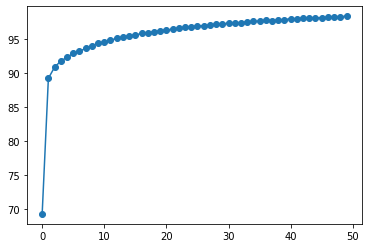

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


test = np.array(train_acc_average)


# ypoints = np.array([3, 8, 1, 10])


ypoints = test

plt.plot(ypoints, marker = 'o')
plt.show()




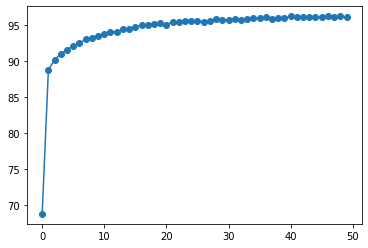

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


test = np.array(val_acc)


# ypoints = np.array([3, 8, 1, 10])


ypoints = test

plt.plot(ypoints, marker = 'o')
plt.show()


